<a href="https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py">mnist_mlpのコード</a>をコピーする。

In [115]:
'''Trains a simple deep NN on the MNIST dataset.

Gets to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

numpyをインポートしておく。

In [116]:
import numpy as np

コードを書き始めた段階では、エポック数指定はひとまず数回でも十分、あとで修正すれば良い。<br>次にmnistデータをロードする。実はtestデータはいらない。

In [117]:
batch_size = 128
epochs = 50

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

古典的な例だが、0から9の数字のうち4と9だけを残すことにする。<br>ここでは便利な書き方をふたつ使っている。<br>ブロードキャスト？による各要素計算。<br>x_train[keep_train_idx]の書き方は、Numpy配列のboolインデックス参照と呼ぶようだ。

In [118]:
keep_train_idx = np.logical_or(y_train == 4, y_train == 9)
keep_test_idx = np.logical_or(y_test ==4, y_test == 9)

x_train = x_train[keep_train_idx]
x_test = x_test[keep_test_idx]
x_train.shape

(11791, 28, 28)

ベクトル化した変数は名前を別にしておくほうが好き。

In [119]:
x_train_vec = x_train.reshape(x_train.shape[0], 784)
x_test_vec = x_test.reshape(x_test.shape[0], 784)
x_train_vec.shape

(11791, 784)

autoencoderを作るだけなら、keras Sequential APIだけで十分である。活性化関数としてはsigmoidを選択する。Dropout層は良い奴なので入れておく。まずは中央に256次元もつautoencoderを構成した。

In [120]:
model = Sequential()
model.add(Dense(256, activation='sigmoid', input_shape=(784,)))
model.add(Dropout(0.3))
model.add(Dense(784, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 784)               201488    
Total params: 402,448
Trainable params: 402,448
Non-trainable params: 0
_________________________________________________________________


出力がなるべく入力と同じになるようにautoencoderを訓練する。損失関数を平均2乗誤差とする。

In [121]:
model.compile(loss='mean_squared_error',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train_vec, x_train_vec,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test_vec, x_test_vec))
score = model.evaluate(x_test_vec, x_test_vec, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 11791 samples, validate on 1991 samples
Epoch 1/50
11791/11791 [==============================] - 2s - loss: 0.0552 - acc: 0.0087 - val_loss: 0.0359 - val_acc: 0.0116
Epoch 2/50
11791/11791 [==============================] - 1s - loss: 0.0307 - acc: 0.0101 - val_loss: 0.0239 - val_acc: 0.0065
Epoch 3/50
11791/11791 [==============================] - 1s - loss: 0.0226 - acc: 0.0089 - val_loss: 0.0184 - val_acc: 0.0100
Epoch 4/50
11791/11791 [==============================] - 1s - loss: 0.0188 - acc: 0.0098 - val_loss: 0.0155 - val_acc: 0.0075
Epoch 5/50
11791/11791 [==============================] - 1s - loss: 0.0166 - acc: 0.0104 - val_loss: 0.0136 - val_acc: 0.0141
Epoch 6/50
11791/11791 [==============================] - 1s - loss: 0.0151 - acc: 0.0131 - val_loss: 0.0119 - val_acc: 0.0070
Epoch 7/50
11791/11791 [==============================] - 1s - loss: 0.0139 - acc: 0.0116 - val_loss: 0.0108 - val_acc: 0.0161
Epoch 8/50
11791/11791 [==============================] - 1s -

## Testing results 

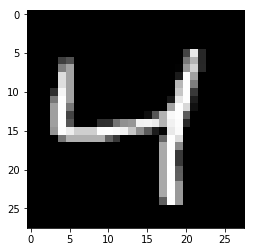

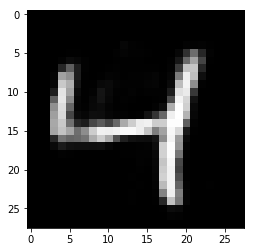

In [122]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(1, 2):
    plt.figure()
    plt.imshow(x_train[i-1])
    predicted = model.predict(x_train_vec[i-1:i]).reshape((28,28))
    plt.figure()
    plt.imshow(predicted)

一応出力が出てきたのだが、入力と同じものが出力に出てきているように見える。入力を圧縮せずに素通しするのは良いautoencoderではない。まだ中間層の要素数が多すぎる。

なおpredictの部分の処理がちょっとややこしくなっているがあまり本質的ではない。

In [125]:
x_train_vec[0:1].shape

(1, 784)

subplotでもう少し一覧性を改善してみる

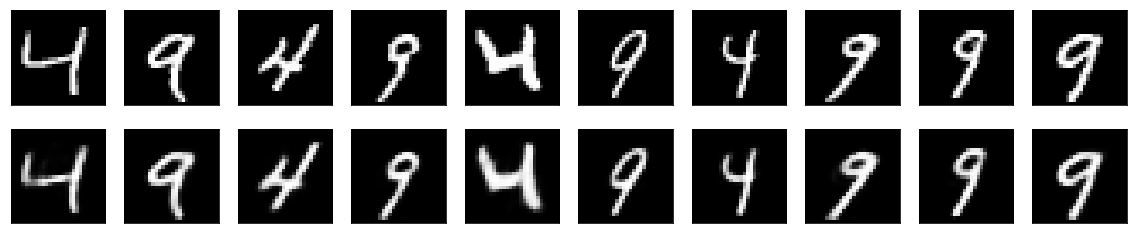

In [126]:
n = 10  # how many digits we will display

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    predicted = model.predict(x_train_vec[i:i+1]).reshape((28,28))
    plt.imshow(predicted)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()